# Poetry generation with LSTM

This notebook is from Lazy Programmer's NLP course (Advanced NLP)

 https://deeplearningcourses.com/c/deep-learning-advanced-nlp

In [1]:
#nlp_class3 poetry.py
from __future__ import print_function, division
from builtins import range, input

import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass


# Load text (Robert Frost's poem)

In [4]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [5]:
# load in the data
# create input dataset and target dataset (the same poem)
input_texts = []
target_texts = []
for line in open('./robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts

In [7]:
len(input_texts), len(input_texts[0]), input_texts[0], input_texts[1435]

(1436,
 42,
 '<sos> Two roads diverged in a yellow wood,',
 "<sos> To make it worth life's while to wake and sport.")

In [9]:
len(target_texts), target_texts[0], target_texts[1435]

(1436,
 'Two roads diverged in a yellow wood, <eos>',
 "To make it worth life's while to wake and sport. <eos>")

## Tokenizer

In [10]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)

In [11]:
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [12]:
len(input_sequences), len(input_sequences[0]), input_sequences[0]

(1436, 8, [1, 104, 537, 538, 9, 7, 539, 540])

In [13]:
len(target_sequences), len(target_sequences[0]), target_sequences[0]

(1436, 8, [104, 537, 538, 9, 7, 539, 540, 2])

In [ ]:
target_sequences

In [14]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)


Max sequence length: 12


In [15]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


## Word to index mapping: word2idx is a dictionary of length 3056

In [16]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [17]:
print(word2idx,end=',')

{'<sos>': 1, '<eos>': 2, 'the': 3, 'to': 4, 'and': 5, 'i': 6, 'a': 7, 'of': 8, 'in': 9, 'you': 10, 'it': 11, 'he': 12, 'that': 13, 'was': 14, 'for': 15, 'but': 16, 'as': 17, 'on': 18, 'with': 19, 'what': 20, 'all': 21, 'they': 22, 'had': 23, 'one': 24, 'me': 25, 'his': 26, 'be': 27, 'if': 28, 'have': 29, 'we': 30, 'not': 31, 'is': 32, 'from': 33, 'she': 34, 'up': 35, 'out': 36, 'like': 37, 'see': 38, 'or': 39, 'where': 40, 'at': 41, 'no': 42, 'when': 43, 'my': 44, 'her': 45, 'so': 46, 'by': 47, 'some': 48, "it's": 49, 'him': 50, "don't": 51, 'them': 52, 'this': 53, 'were': 54, 'there': 55, 'been': 56, 'can': 57, 'too': 58, 'are': 59, 'tell': 60, "he's": 61, 'do': 62, 'old': 63, "'i": 64, 'could': 65, 'know': 66, 'down': 67, 'here': 68, 'an': 69, 'off': 70, 'your': 71, 'think': 72, 'must': 73, 'only': 74, 'make': 75, 'let': 76, 'just': 77, 'come': 78, 'will': 79, 'would': 80, 'way': 81, 'made': 82, 'say': 83, 'our': 84, 'take': 85, 'it.': 86, 'get': 87, 'now': 88, "can't": 89, 'said': 9

In [18]:
len(word2idx)

3056

In [19]:
list(word2idx.keys())[:10]

['<sos>', '<eos>', 'the', 'to', 'and', 'i', 'a', 'of', 'in', 'you']

In [20]:
list(word2idx.values())[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [21]:
list(word2idx.items())[:10]

[('<sos>', 1),
 ('<eos>', 2),
 ('the', 3),
 ('to', 4),
 ('and', 5),
 ('i', 6),
 ('a', 7),
 ('of', 8),
 ('in', 9),
 ('you', 10)]

# Loading GloVe: word2vec is a dictionary of shape (4e5, 1e2)

In [22]:
EMBEDDING_DIM

50

In [23]:
# load in pre-trained word vectors

print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [24]:
len(word2vec), list(word2vec.keys())[:8]

(400000, ['the', ',', '.', 'of', 'to', 'and', 'in', 'a'])

In [25]:
list(word2vec.items())[3:5]

[('of',
  array([ 0.70853  ,  0.57088  , -0.4716   ,  0.18048  ,  0.54449  ,
          0.72603  ,  0.18157  , -0.52393  ,  0.10381  , -0.17566  ,
          0.078852 , -0.36216  , -0.11829  , -0.83336  ,  0.11917  ,
         -0.16605  ,  0.061555 , -0.012719 , -0.56623  ,  0.013616 ,
          0.22851  , -0.14396  , -0.067549 , -0.38157  , -0.23698  ,
         -1.7037   , -0.86692  , -0.26704  , -0.2589   ,  0.1767   ,
          3.8676   , -0.1613   , -0.13273  , -0.68881  ,  0.18444  ,
          0.0052464, -0.33874  , -0.078956 ,  0.24185  ,  0.36576  ,
         -0.34727  ,  0.28483  ,  0.075693 , -0.062178 , -0.38988  ,
          0.22902  , -0.21617  , -0.22562  , -0.093918 , -0.80375  ],
        dtype=float32)),
 ('to',
  array([ 0.68047 , -0.039263,  0.30186 , -0.17792 ,  0.42962 ,  0.032246,
         -0.41376 ,  0.13228 , -0.29847 , -0.085253,  0.17118 ,  0.22419 ,
         -0.10046 , -0.43653 ,  0.33418 ,  0.67846 ,  0.057204, -0.34448 ,
         -0.42785 , -0.43275 ,  0.55963 ,  

## Create embedding layer

In [27]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

len(word2idx) + 1, num_words, embedding_matrix.shape

(3057, 3000, (3000, 50))

In [28]:
len(word2idx), list(word2idx.values())[0], list(word2idx.items())[3055]

(3056, 1, ('sport.', 3056))

In [29]:
len(word2vec), list(word2vec.values())[3055], word2vec.get('sport.')

(400000,
 array([ 0.53452  ,  0.24252  ,  1.585    , -0.6621   ,  0.40865  ,
         0.035883 , -0.35193  , -0.35479  ,  0.29829  ,  0.16791  ,
        -0.0056845, -1.3639   ,  1.3901   , -1.4262   ,  1.8526   ,
        -0.56317  ,  0.031229 ,  0.76752  , -0.66853  , -0.45274  ,
         0.40797  , -0.43635  , -0.086689 , -0.39278  , -0.43377  ,
        -0.67368  ,  0.28596  , -0.89076  , -0.21354  , -0.15938  ,
         2.5024   ,  0.60384  , -0.025529 ,  0.46988  , -0.38791  ,
         0.29368  ,  0.2521   , -0.45888  ,  0.14531  , -0.31504  ,
         0.15432  ,  0.36499  ,  0.67487  ,  0.17843  , -0.10076  ,
        -0.89717  , -0.78124  ,  0.15775  , -1.0822   , -0.5304   ],
       dtype=float32),
 None)

In [30]:
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix[0], embedding_matrix[10]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-1.09190005e-03,  3.33240002e-01,  3.57430011e-01, -5.40409982e-01,
         8.20320010e-01, -4.93910015e-01, -3.25879991e-01,  1.99720007e-03,
        -2.38289997e-01,  3.55540007e-01, -6.06549978e-01,  9.89319980e-01,
        -2.17859998e-01,  1.12360001e-01,  1.14940000e+00,  7.32840002e-01,
         5.11820018e-01,  2.92869985e-01,  2.83879995e-01, -1.35899997e+00,
        -3.79509985e-01,  5.09429991e-01,  7.07099974e-01,  6.29410028e-01,
         1.05340004e+00, -2.17560005e+00, -1.32040000e+00,  4.00009990e-01,
         1.57410002e+00, -1.65999997e+00,  3.77209997e+00,  8.69490027e-01,
        -8.04390013e-01,  1.83899999e-01, -3.43320012e-01,  1.07140001e-02,
         2.39690006e-01,  6.67480007e-02,  7.01170027e-01, -7.37020016e-01,
         2.087

In [32]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

In [33]:
embedding_layer

## Build the LSTM

In [34]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [35]:
one_hot_targets.shape

(1436, 12, 3000)

In [36]:
one_hot_targets[10][10]

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
#Define layers
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
dense = Dense(num_words, activation='softmax')
# Define 'forward' sequence
x = embedding_layer(input_)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
output = dense(x)

Building model...


In [38]:
model = Model([input_, initial_h, initial_c], output)

In [39]:
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(learning_rate=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)


In [40]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/2000
9/9 [==============================] - 4s 203ms/step - loss: 5.3897 - accuracy: 0.0386 - val_loss: 5.0427 - val_accuracy: 0.0833
Epoch 2/2000
9/9 [==============================] - 1s 110ms/step - loss: 4.6024 - accuracy: 0.0833 - val_loss: 4.7396 - val_accuracy: 0.0833
Epoch 3/2000
9/9 [==============================] - 1s 109ms/step - loss: 4.3764 - accuracy: 0.0833 - val_loss: 4.7883 - val_accuracy: 0.0833
Epoch 4/2000
9/9 [==============================] - 1s 116ms/step - loss: 4.3324 - accuracy: 0.0833 - val_loss: 4.8158 - val_accuracy: 0.0833
Epoch 5/2000
9/9 [==============================] - 1s 120ms/step - loss: 4.3197 - accuracy: 0.0833 - val_loss: 4.8138 - val_accuracy: 0.0833
Epoch 6/2000
9/9 [==============================] - 1s 118ms/step - loss: 4.2985 - accuracy: 0.0833 - val_loss: 4.7770 - val_accuracy: 0.0833
Epoch 7/2000
9/9 [==============================] - 1s 134ms/step - loss: 4.2711 - accuracy: 0.0833 - val_loss: 4.7200 - val_accur

9/9 [==============================] - 1s 127ms/step - loss: 3.1381 - accuracy: 0.1762 - val_loss: 4.8681 - val_accuracy: 0.0914
Epoch 59/2000
9/9 [==============================] - 1s 136ms/step - loss: 3.1200 - accuracy: 0.1784 - val_loss: 4.8769 - val_accuracy: 0.0926
Epoch 60/2000
9/9 [==============================] - 1s 127ms/step - loss: 3.0964 - accuracy: 0.1821 - val_loss: 4.8817 - val_accuracy: 0.0923
Epoch 61/2000
9/9 [==============================] - 1s 138ms/step - loss: 3.0752 - accuracy: 0.1828 - val_loss: 4.8868 - val_accuracy: 0.0920
Epoch 62/2000
9/9 [==============================] - 1s 136ms/step - loss: 3.0554 - accuracy: 0.1873 - val_loss: 4.8984 - val_accuracy: 0.0938
Epoch 63/2000
9/9 [==============================] - 1s 133ms/step - loss: 3.0343 - accuracy: 0.1863 - val_loss: 4.9091 - val_accuracy: 0.0938
Epoch 64/2000
9/9 [==============================] - 1s 135ms/step - loss: 3.0103 - accuracy: 0.1893 - val_loss: 4.9113 - val_accuracy: 0.0935
Epoch 65/2000

9/9 [==============================] - 1s 135ms/step - loss: 2.3390 - accuracy: 0.2470 - val_loss: 5.5169 - val_accuracy: 0.0871
Epoch 116/2000
9/9 [==============================] - 1s 150ms/step - loss: 2.3325 - accuracy: 0.2476 - val_loss: 5.5419 - val_accuracy: 0.0819
Epoch 117/2000
9/9 [==============================] - 1s 146ms/step - loss: 2.3258 - accuracy: 0.2459 - val_loss: 5.5460 - val_accuracy: 0.0848
Epoch 118/2000
9/9 [==============================] - 1s 139ms/step - loss: 2.3166 - accuracy: 0.2483 - val_loss: 5.5602 - val_accuracy: 0.0865
Epoch 119/2000
9/9 [==============================] - 1s 142ms/step - loss: 2.3046 - accuracy: 0.2504 - val_loss: 5.5785 - val_accuracy: 0.0845
Epoch 120/2000
9/9 [==============================] - 1s 151ms/step - loss: 2.2977 - accuracy: 0.2519 - val_loss: 5.5912 - val_accuracy: 0.0848
Epoch 121/2000
9/9 [==============================] - 1s 146ms/step - loss: 2.2884 - accuracy: 0.2514 - val_loss: 5.5909 - val_accuracy: 0.0845
Epoch 1

Epoch 172/2000
9/9 [==============================] - 1s 136ms/step - loss: 1.9503 - accuracy: 0.3038 - val_loss: 6.3284 - val_accuracy: 0.0787
Epoch 173/2000
9/9 [==============================] - 1s 146ms/step - loss: 1.9447 - accuracy: 0.3047 - val_loss: 6.3559 - val_accuracy: 0.0796
Epoch 174/2000
9/9 [==============================] - 1s 144ms/step - loss: 1.9383 - accuracy: 0.3064 - val_loss: 6.3488 - val_accuracy: 0.0781
Epoch 175/2000
9/9 [==============================] - 1s 139ms/step - loss: 1.9318 - accuracy: 0.3039 - val_loss: 6.3760 - val_accuracy: 0.0778
Epoch 176/2000
9/9 [==============================] - 1s 155ms/step - loss: 1.9310 - accuracy: 0.3068 - val_loss: 6.3891 - val_accuracy: 0.0784
Epoch 177/2000
9/9 [==============================] - 1s 139ms/step - loss: 1.9290 - accuracy: 0.3068 - val_loss: 6.4051 - val_accuracy: 0.0804
Epoch 178/2000
9/9 [==============================] - 1s 141ms/step - loss: 1.9257 - accuracy: 0.3063 - val_loss: 6.4480 - val_accuracy:

Epoch 229/2000
9/9 [==============================] - 1s 161ms/step - loss: 1.7144 - accuracy: 0.3436 - val_loss: 7.1761 - val_accuracy: 0.0755
Epoch 230/2000
9/9 [==============================] - 2s 174ms/step - loss: 1.7102 - accuracy: 0.3470 - val_loss: 7.1710 - val_accuracy: 0.0718
Epoch 231/2000
9/9 [==============================] - 1s 156ms/step - loss: 1.7038 - accuracy: 0.3484 - val_loss: 7.1724 - val_accuracy: 0.0729
Epoch 232/2000
9/9 [==============================] - 1s 165ms/step - loss: 1.7000 - accuracy: 0.3455 - val_loss: 7.1920 - val_accuracy: 0.0735
Epoch 233/2000
9/9 [==============================] - 1s 148ms/step - loss: 1.6971 - accuracy: 0.3509 - val_loss: 7.2020 - val_accuracy: 0.0715
Epoch 234/2000
9/9 [==============================] - 1s 141ms/step - loss: 1.6916 - accuracy: 0.3511 - val_loss: 7.2158 - val_accuracy: 0.0712
Epoch 235/2000
9/9 [==============================] - 1s 157ms/step - loss: 1.6910 - accuracy: 0.3506 - val_loss: 7.2300 - val_accuracy:

Epoch 286/2000
9/9 [==============================] - 2s 217ms/step - loss: 1.5509 - accuracy: 0.3739 - val_loss: 7.9847 - val_accuracy: 0.0749
Epoch 287/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.5547 - accuracy: 0.3739 - val_loss: 8.0297 - val_accuracy: 0.0729
Epoch 288/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.5475 - accuracy: 0.3741 - val_loss: 8.0282 - val_accuracy: 0.0726
Epoch 289/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.5437 - accuracy: 0.3744 - val_loss: 8.0729 - val_accuracy: 0.0712
Epoch 290/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.5355 - accuracy: 0.3754 - val_loss: 8.0515 - val_accuracy: 0.0738
Epoch 291/2000
9/9 [==============================] - 1s 129ms/step - loss: 1.5302 - accuracy: 0.3798 - val_loss: 8.1096 - val_accuracy: 0.0729
Epoch 292/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.5282 - accuracy: 0.3799 - val_loss: 8.1001 - val_accuracy:

Epoch 343/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.4207 - accuracy: 0.3964 - val_loss: 8.8804 - val_accuracy: 0.0726
Epoch 344/2000
9/9 [==============================] - 1s 132ms/step - loss: 1.4177 - accuracy: 0.3976 - val_loss: 8.8918 - val_accuracy: 0.0738
Epoch 345/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.4145 - accuracy: 0.3989 - val_loss: 8.8875 - val_accuracy: 0.0755
Epoch 346/2000
9/9 [==============================] - 1s 133ms/step - loss: 1.4174 - accuracy: 0.3977 - val_loss: 8.9379 - val_accuracy: 0.0755
Epoch 347/2000
9/9 [==============================] - 1s 137ms/step - loss: 1.4190 - accuracy: 0.3995 - val_loss: 8.9230 - val_accuracy: 0.0735
Epoch 348/2000
9/9 [==============================] - 1s 130ms/step - loss: 1.4180 - accuracy: 0.3967 - val_loss: 8.9637 - val_accuracy: 0.0735
Epoch 349/2000
9/9 [==============================] - 1s 137ms/step - loss: 1.4183 - accuracy: 0.3973 - val_loss: 8.9915 - val_accuracy:

Epoch 400/2000
9/9 [==============================] - 1s 133ms/step - loss: 1.3326 - accuracy: 0.4156 - val_loss: 9.7595 - val_accuracy: 0.0735
Epoch 401/2000
9/9 [==============================] - 2s 176ms/step - loss: 1.3300 - accuracy: 0.4145 - val_loss: 9.8095 - val_accuracy: 0.0723
Epoch 402/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.3281 - accuracy: 0.4168 - val_loss: 9.8238 - val_accuracy: 0.0738
Epoch 403/2000
9/9 [==============================] - 1s 126ms/step - loss: 1.3288 - accuracy: 0.4173 - val_loss: 9.8453 - val_accuracy: 0.0747
Epoch 404/2000
9/9 [==============================] - 1s 123ms/step - loss: 1.3285 - accuracy: 0.4159 - val_loss: 9.7933 - val_accuracy: 0.0729
Epoch 405/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.3274 - accuracy: 0.4164 - val_loss: 9.8459 - val_accuracy: 0.0732
Epoch 406/2000
9/9 [==============================] - 1s 142ms/step - loss: 1.3268 - accuracy: 0.4172 - val_loss: 9.8617 - val_accuracy:

9/9 [==============================] - 1s 133ms/step - loss: 1.2658 - accuracy: 0.4273 - val_loss: 10.7541 - val_accuracy: 0.0726
Epoch 457/2000
9/9 [==============================] - 1s 129ms/step - loss: 1.2673 - accuracy: 0.4281 - val_loss: 10.7508 - val_accuracy: 0.0677
Epoch 458/2000
9/9 [==============================] - 1s 131ms/step - loss: 1.2746 - accuracy: 0.4263 - val_loss: 10.7665 - val_accuracy: 0.0703
Epoch 459/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.2829 - accuracy: 0.4241 - val_loss: 10.7572 - val_accuracy: 0.0706
Epoch 460/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.2877 - accuracy: 0.4217 - val_loss: 10.7700 - val_accuracy: 0.0715
Epoch 461/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.2849 - accuracy: 0.4238 - val_loss: 10.8185 - val_accuracy: 0.0694
Epoch 462/2000
9/9 [==============================] - 1s 123ms/step - loss: 1.2738 - accuracy: 0.4276 - val_loss: 10.8058 - val_accuracy: 0.0706


9/9 [==============================] - 1s 124ms/step - loss: 1.2191 - accuracy: 0.4380 - val_loss: 11.7006 - val_accuracy: 0.0706
Epoch 513/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.2208 - accuracy: 0.4366 - val_loss: 11.6459 - val_accuracy: 0.0692
Epoch 514/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.2162 - accuracy: 0.4401 - val_loss: 11.6973 - val_accuracy: 0.0689
Epoch 515/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.2190 - accuracy: 0.4374 - val_loss: 11.7088 - val_accuracy: 0.0692
Epoch 516/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.2209 - accuracy: 0.4390 - val_loss: 11.7493 - val_accuracy: 0.0700
Epoch 517/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.2231 - accuracy: 0.4368 - val_loss: 11.7760 - val_accuracy: 0.0718
Epoch 518/2000
9/9 [==============================] - 1s 121ms/step - loss: 1.2196 - accuracy: 0.4369 - val_loss: 11.7482 - val_accuracy: 0.0689


9/9 [==============================] - 1s 126ms/step - loss: 1.1993 - accuracy: 0.4402 - val_loss: 12.6178 - val_accuracy: 0.0712
Epoch 569/2000
9/9 [==============================] - 1s 122ms/step - loss: 1.1965 - accuracy: 0.4397 - val_loss: 12.6187 - val_accuracy: 0.0689
Epoch 570/2000
9/9 [==============================] - 1s 159ms/step - loss: 1.1956 - accuracy: 0.4423 - val_loss: 12.6645 - val_accuracy: 0.0706
Epoch 571/2000
9/9 [==============================] - 1s 138ms/step - loss: 1.1966 - accuracy: 0.4405 - val_loss: 12.6971 - val_accuracy: 0.0703
Epoch 572/2000
9/9 [==============================] - 1s 123ms/step - loss: 1.1910 - accuracy: 0.4422 - val_loss: 12.7445 - val_accuracy: 0.0700
Epoch 573/2000
9/9 [==============================] - 1s 143ms/step - loss: 1.1893 - accuracy: 0.4421 - val_loss: 12.7337 - val_accuracy: 0.0694
Epoch 574/2000
9/9 [==============================] - 1s 122ms/step - loss: 1.1850 - accuracy: 0.4427 - val_loss: 12.7316 - val_accuracy: 0.0718


9/9 [==============================] - 1s 126ms/step - loss: 1.1594 - accuracy: 0.4503 - val_loss: 13.5779 - val_accuracy: 0.0692
Epoch 625/2000
9/9 [==============================] - 1s 123ms/step - loss: 1.1565 - accuracy: 0.4503 - val_loss: 13.5522 - val_accuracy: 0.0709
Epoch 626/2000
9/9 [==============================] - 1s 123ms/step - loss: 1.1560 - accuracy: 0.4495 - val_loss: 13.5934 - val_accuracy: 0.0700
Epoch 627/2000
9/9 [==============================] - 1s 123ms/step - loss: 1.1612 - accuracy: 0.4482 - val_loss: 13.6828 - val_accuracy: 0.0694
Epoch 628/2000
9/9 [==============================] - 1s 134ms/step - loss: 1.1586 - accuracy: 0.4509 - val_loss: 13.6175 - val_accuracy: 0.0686
Epoch 629/2000
9/9 [==============================] - 1s 147ms/step - loss: 1.1503 - accuracy: 0.4501 - val_loss: 13.5736 - val_accuracy: 0.0709
Epoch 630/2000
9/9 [==============================] - 1s 126ms/step - loss: 1.1527 - accuracy: 0.4503 - val_loss: 13.6648 - val_accuracy: 0.0697


9/9 [==============================] - 1s 112ms/step - loss: 1.1450 - accuracy: 0.4503 - val_loss: 14.3723 - val_accuracy: 0.0697
Epoch 681/2000
9/9 [==============================] - 1s 112ms/step - loss: 1.1485 - accuracy: 0.4487 - val_loss: 14.5050 - val_accuracy: 0.0697
Epoch 682/2000
9/9 [==============================] - 1s 113ms/step - loss: 1.1496 - accuracy: 0.4501 - val_loss: 14.4239 - val_accuracy: 0.0680
Epoch 683/2000
9/9 [==============================] - 1s 111ms/step - loss: 1.1424 - accuracy: 0.4515 - val_loss: 14.4921 - val_accuracy: 0.0677
Epoch 684/2000
9/9 [==============================] - 1s 110ms/step - loss: 1.1442 - accuracy: 0.4514 - val_loss: 14.4882 - val_accuracy: 0.0677
Epoch 685/2000
9/9 [==============================] - 1s 110ms/step - loss: 1.1422 - accuracy: 0.4522 - val_loss: 14.4790 - val_accuracy: 0.0686
Epoch 686/2000
9/9 [==============================] - 1s 110ms/step - loss: 1.1457 - accuracy: 0.4505 - val_loss: 14.5230 - val_accuracy: 0.0686


9/9 [==============================] - 1s 137ms/step - loss: 1.1338 - accuracy: 0.4516 - val_loss: 15.4195 - val_accuracy: 0.0671
Epoch 737/2000
9/9 [==============================] - 1s 138ms/step - loss: 1.1316 - accuracy: 0.4530 - val_loss: 15.3564 - val_accuracy: 0.0668
Epoch 738/2000
9/9 [==============================] - 1s 132ms/step - loss: 1.1276 - accuracy: 0.4542 - val_loss: 15.3444 - val_accuracy: 0.0680
Epoch 739/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.1232 - accuracy: 0.4567 - val_loss: 15.3541 - val_accuracy: 0.0671
Epoch 740/2000
9/9 [==============================] - 1s 123ms/step - loss: 1.1182 - accuracy: 0.4568 - val_loss: 15.4021 - val_accuracy: 0.0663
Epoch 741/2000
9/9 [==============================] - 1s 129ms/step - loss: 1.1128 - accuracy: 0.4605 - val_loss: 15.3904 - val_accuracy: 0.0683
Epoch 742/2000
9/9 [==============================] - 1s 137ms/step - loss: 1.1123 - accuracy: 0.4586 - val_loss: 15.4779 - val_accuracy: 0.0651


9/9 [==============================] - 1s 147ms/step - loss: 1.0928 - accuracy: 0.4631 - val_loss: 16.2970 - val_accuracy: 0.0654
Epoch 793/2000
9/9 [==============================] - 1s 134ms/step - loss: 1.0944 - accuracy: 0.4630 - val_loss: 16.2563 - val_accuracy: 0.0674
Epoch 794/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.0900 - accuracy: 0.4633 - val_loss: 16.3180 - val_accuracy: 0.0660
Epoch 795/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.0877 - accuracy: 0.4625 - val_loss: 16.2689 - val_accuracy: 0.0677
Epoch 796/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.0984 - accuracy: 0.4614 - val_loss: 16.3771 - val_accuracy: 0.0660
Epoch 797/2000
9/9 [==============================] - 1s 127ms/step - loss: 1.1032 - accuracy: 0.4586 - val_loss: 16.2895 - val_accuracy: 0.0668
Epoch 798/2000
9/9 [==============================] - 1s 127ms/step - loss: 1.1065 - accuracy: 0.4601 - val_loss: 16.3619 - val_accuracy: 0.0660


9/9 [==============================] - 2s 282ms/step - loss: 1.0675 - accuracy: 0.4684 - val_loss: 17.2214 - val_accuracy: 0.0645
Epoch 849/2000
9/9 [==============================] - 1s 137ms/step - loss: 1.0737 - accuracy: 0.4661 - val_loss: 17.1861 - val_accuracy: 0.0625
Epoch 850/2000
9/9 [==============================] - 1s 135ms/step - loss: 1.0771 - accuracy: 0.4653 - val_loss: 17.1769 - val_accuracy: 0.0637
Epoch 851/2000
9/9 [==============================] - 1s 151ms/step - loss: 1.0792 - accuracy: 0.4628 - val_loss: 17.1966 - val_accuracy: 0.0639
Epoch 852/2000
9/9 [==============================] - 1s 129ms/step - loss: 1.0747 - accuracy: 0.4646 - val_loss: 17.2395 - val_accuracy: 0.0648
Epoch 853/2000
9/9 [==============================] - 1s 127ms/step - loss: 1.0859 - accuracy: 0.4628 - val_loss: 17.2627 - val_accuracy: 0.0634
Epoch 854/2000
9/9 [==============================] - 1s 131ms/step - loss: 1.0885 - accuracy: 0.4628 - val_loss: 17.2851 - val_accuracy: 0.0651


9/9 [==============================] - 1s 129ms/step - loss: 1.0729 - accuracy: 0.4667 - val_loss: 18.0656 - val_accuracy: 0.0628
Epoch 905/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.0825 - accuracy: 0.4615 - val_loss: 18.1739 - val_accuracy: 0.0613
Epoch 906/2000
9/9 [==============================] - 1s 129ms/step - loss: 1.0771 - accuracy: 0.4642 - val_loss: 18.0882 - val_accuracy: 0.0622
Epoch 907/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.0700 - accuracy: 0.4661 - val_loss: 18.1029 - val_accuracy: 0.0645
Epoch 908/2000
9/9 [==============================] - 1s 127ms/step - loss: 1.0634 - accuracy: 0.4691 - val_loss: 18.1434 - val_accuracy: 0.0576
Epoch 909/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.0603 - accuracy: 0.4670 - val_loss: 18.1147 - val_accuracy: 0.0651
Epoch 910/2000
9/9 [==============================] - 1s 130ms/step - loss: 1.0661 - accuracy: 0.4660 - val_loss: 18.2809 - val_accuracy: 0.0619


9/9 [==============================] - 1s 131ms/step - loss: 1.0729 - accuracy: 0.4659 - val_loss: 18.9829 - val_accuracy: 0.0619
Epoch 961/2000
9/9 [==============================] - 1s 129ms/step - loss: 1.0684 - accuracy: 0.4661 - val_loss: 18.9861 - val_accuracy: 0.0625
Epoch 962/2000
9/9 [==============================] - 1s 128ms/step - loss: 1.0664 - accuracy: 0.4662 - val_loss: 19.0943 - val_accuracy: 0.0564
Epoch 963/2000
9/9 [==============================] - 1s 144ms/step - loss: 1.0807 - accuracy: 0.4644 - val_loss: 19.0439 - val_accuracy: 0.0593
Epoch 964/2000
9/9 [==============================] - 1s 136ms/step - loss: 1.0762 - accuracy: 0.4633 - val_loss: 19.1458 - val_accuracy: 0.0538
Epoch 965/2000
9/9 [==============================] - 1s 146ms/step - loss: 1.0757 - accuracy: 0.4641 - val_loss: 19.0936 - val_accuracy: 0.0553
Epoch 966/2000
9/9 [==============================] - 1s 134ms/step - loss: 1.0786 - accuracy: 0.4633 - val_loss: 19.1004 - val_accuracy: 0.0576


9/9 [==============================] - 1s 130ms/step - loss: 1.0502 - accuracy: 0.4681 - val_loss: 19.8686 - val_accuracy: 0.0518
Epoch 1017/2000
9/9 [==============================] - 1s 130ms/step - loss: 1.0460 - accuracy: 0.4729 - val_loss: 19.8105 - val_accuracy: 0.0535
Epoch 1018/2000
9/9 [==============================] - 1s 134ms/step - loss: 1.0501 - accuracy: 0.4678 - val_loss: 19.7334 - val_accuracy: 0.0538
Epoch 1019/2000
9/9 [==============================] - 1s 143ms/step - loss: 1.0860 - accuracy: 0.4605 - val_loss: 19.7925 - val_accuracy: 0.0561
Epoch 1020/2000
9/9 [==============================] - 1s 139ms/step - loss: 1.0865 - accuracy: 0.4577 - val_loss: 19.8339 - val_accuracy: 0.0535
Epoch 1021/2000
9/9 [==============================] - 1s 167ms/step - loss: 1.0821 - accuracy: 0.4609 - val_loss: 19.9934 - val_accuracy: 0.0611
Epoch 1022/2000
9/9 [==============================] - 1s 140ms/step - loss: 1.0776 - accuracy: 0.4618 - val_loss: 19.9813 - val_accuracy: 0

9/9 [==============================] - 1s 128ms/step - loss: 1.0354 - accuracy: 0.4725 - val_loss: 20.6069 - val_accuracy: 0.0544
Epoch 1073/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.0493 - accuracy: 0.4688 - val_loss: 20.7256 - val_accuracy: 0.0538
Epoch 1074/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.0772 - accuracy: 0.4596 - val_loss: 20.7667 - val_accuracy: 0.0521
Epoch 1075/2000
9/9 [==============================] - 1s 127ms/step - loss: 1.0855 - accuracy: 0.4583 - val_loss: 20.7546 - val_accuracy: 0.0495
Epoch 1076/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.0897 - accuracy: 0.4591 - val_loss: 20.7762 - val_accuracy: 0.0541
Epoch 1077/2000
9/9 [==============================] - 1s 124ms/step - loss: 1.1041 - accuracy: 0.4564 - val_loss: 20.6945 - val_accuracy: 0.0550
Epoch 1078/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.0836 - accuracy: 0.4585 - val_loss: 20.8341 - val_accuracy: 0

9/9 [==============================] - 1s 149ms/step - loss: 1.0178 - accuracy: 0.4769 - val_loss: 21.5947 - val_accuracy: 0.0489
Epoch 1129/2000
9/9 [==============================] - 1s 132ms/step - loss: 1.0116 - accuracy: 0.4777 - val_loss: 21.5856 - val_accuracy: 0.0486
Epoch 1130/2000
9/9 [==============================] - 1s 133ms/step - loss: 1.0150 - accuracy: 0.4782 - val_loss: 21.5999 - val_accuracy: 0.0469
Epoch 1131/2000
9/9 [==============================] - 1s 136ms/step - loss: 1.0108 - accuracy: 0.4786 - val_loss: 21.5700 - val_accuracy: 0.0492
Epoch 1132/2000
9/9 [==============================] - 1s 140ms/step - loss: 1.0123 - accuracy: 0.4788 - val_loss: 21.5329 - val_accuracy: 0.0492
Epoch 1133/2000
9/9 [==============================] - 1s 137ms/step - loss: 1.0104 - accuracy: 0.4791 - val_loss: 21.6656 - val_accuracy: 0.0489
Epoch 1134/2000
9/9 [==============================] - 1s 149ms/step - loss: 1.0115 - accuracy: 0.4771 - val_loss: 21.6757 - val_accuracy: 0

9/9 [==============================] - 1s 125ms/step - loss: 0.9963 - accuracy: 0.4825 - val_loss: 22.4029 - val_accuracy: 0.0472
Epoch 1185/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.0044 - accuracy: 0.4805 - val_loss: 22.4987 - val_accuracy: 0.0475
Epoch 1186/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.0060 - accuracy: 0.4783 - val_loss: 22.6095 - val_accuracy: 0.0486
Epoch 1187/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.0189 - accuracy: 0.4763 - val_loss: 22.4988 - val_accuracy: 0.0480
Epoch 1188/2000
9/9 [==============================] - 1s 126ms/step - loss: 1.0158 - accuracy: 0.4764 - val_loss: 22.4771 - val_accuracy: 0.0460
Epoch 1189/2000
9/9 [==============================] - 1s 141ms/step - loss: 1.0202 - accuracy: 0.4747 - val_loss: 22.5686 - val_accuracy: 0.0501
Epoch 1190/2000
9/9 [==============================] - 1s 122ms/step - loss: 1.0168 - accuracy: 0.4790 - val_loss: 22.6061 - val_accuracy: 0

9/9 [==============================] - 1s 152ms/step - loss: 1.0080 - accuracy: 0.4773 - val_loss: 23.2528 - val_accuracy: 0.0451
Epoch 1241/2000
9/9 [==============================] - 1s 130ms/step - loss: 1.0041 - accuracy: 0.4800 - val_loss: 23.3008 - val_accuracy: 0.0486
Epoch 1242/2000
9/9 [==============================] - 1s 131ms/step - loss: 1.0073 - accuracy: 0.4776 - val_loss: 23.2744 - val_accuracy: 0.0466
Epoch 1243/2000
9/9 [==============================] - 1s 134ms/step - loss: 0.9987 - accuracy: 0.4779 - val_loss: 23.1480 - val_accuracy: 0.0463
Epoch 1244/2000
9/9 [==============================] - 1s 130ms/step - loss: 0.9973 - accuracy: 0.4782 - val_loss: 23.2691 - val_accuracy: 0.0454
Epoch 1245/2000
9/9 [==============================] - 1s 134ms/step - loss: 0.9955 - accuracy: 0.4804 - val_loss: 23.3630 - val_accuracy: 0.0448
Epoch 1246/2000
9/9 [==============================] - 1s 125ms/step - loss: 1.0028 - accuracy: 0.4805 - val_loss: 23.3391 - val_accuracy: 0

9/9 [==============================] - 1s 149ms/step - loss: 1.0231 - accuracy: 0.4739 - val_loss: 24.1234 - val_accuracy: 0.0475
Epoch 1297/2000
9/9 [==============================] - 1s 140ms/step - loss: 1.0142 - accuracy: 0.4736 - val_loss: 24.0368 - val_accuracy: 0.0483
Epoch 1298/2000
9/9 [==============================] - 1s 141ms/step - loss: 1.0198 - accuracy: 0.4756 - val_loss: 24.0834 - val_accuracy: 0.0469
Epoch 1299/2000
9/9 [==============================] - 1s 141ms/step - loss: 1.0217 - accuracy: 0.4763 - val_loss: 24.2214 - val_accuracy: 0.0489
Epoch 1300/2000
9/9 [==============================] - 1s 131ms/step - loss: 1.0036 - accuracy: 0.4781 - val_loss: 24.1469 - val_accuracy: 0.0509
Epoch 1301/2000
9/9 [==============================] - 1s 135ms/step - loss: 1.0035 - accuracy: 0.4768 - val_loss: 24.1859 - val_accuracy: 0.0475
Epoch 1302/2000
9/9 [==============================] - 1s 136ms/step - loss: 0.9937 - accuracy: 0.4806 - val_loss: 24.0930 - val_accuracy: 0

9/9 [==============================] - 1s 125ms/step - loss: 1.0058 - accuracy: 0.4768 - val_loss: 24.7455 - val_accuracy: 0.0454
Epoch 1353/2000
9/9 [==============================] - 1s 133ms/step - loss: 1.0003 - accuracy: 0.4771 - val_loss: 24.8102 - val_accuracy: 0.0509
Epoch 1354/2000
9/9 [==============================] - 1s 132ms/step - loss: 0.9956 - accuracy: 0.4781 - val_loss: 24.7145 - val_accuracy: 0.0448
Epoch 1355/2000
9/9 [==============================] - 1s 126ms/step - loss: 0.9933 - accuracy: 0.4784 - val_loss: 24.7730 - val_accuracy: 0.0477
Epoch 1356/2000
9/9 [==============================] - 1s 137ms/step - loss: 1.0005 - accuracy: 0.4784 - val_loss: 24.8910 - val_accuracy: 0.0492
Epoch 1357/2000
9/9 [==============================] - 1s 142ms/step - loss: 0.9936 - accuracy: 0.4782 - val_loss: 24.7346 - val_accuracy: 0.0457
Epoch 1358/2000
9/9 [==============================] - 1s 141ms/step - loss: 0.9977 - accuracy: 0.4774 - val_loss: 24.9195 - val_accuracy: 0

9/9 [==============================] - 1s 131ms/step - loss: 1.0084 - accuracy: 0.4768 - val_loss: 25.5845 - val_accuracy: 0.0451
Epoch 1409/2000
9/9 [==============================] - 1s 128ms/step - loss: 0.9982 - accuracy: 0.4786 - val_loss: 25.5070 - val_accuracy: 0.0472
Epoch 1410/2000
9/9 [==============================] - 1s 133ms/step - loss: 1.0113 - accuracy: 0.4765 - val_loss: 25.4679 - val_accuracy: 0.0440
Epoch 1411/2000
9/9 [==============================] - 1s 133ms/step - loss: 1.0088 - accuracy: 0.4742 - val_loss: 25.5573 - val_accuracy: 0.0466
Epoch 1412/2000
9/9 [==============================] - 1s 136ms/step - loss: 0.9997 - accuracy: 0.4765 - val_loss: 25.5706 - val_accuracy: 0.0477
Epoch 1413/2000
9/9 [==============================] - 1s 145ms/step - loss: 1.0057 - accuracy: 0.4743 - val_loss: 25.5471 - val_accuracy: 0.0469
Epoch 1414/2000
9/9 [==============================] - 1s 154ms/step - loss: 1.0111 - accuracy: 0.4731 - val_loss: 25.5499 - val_accuracy: 0

9/9 [==============================] - 1s 127ms/step - loss: 0.9734 - accuracy: 0.4856 - val_loss: 26.2763 - val_accuracy: 0.0448
Epoch 1465/2000
9/9 [==============================] - 1s 136ms/step - loss: 0.9724 - accuracy: 0.4874 - val_loss: 26.2303 - val_accuracy: 0.0440
Epoch 1466/2000
9/9 [==============================] - 1s 138ms/step - loss: 0.9761 - accuracy: 0.4866 - val_loss: 26.1624 - val_accuracy: 0.0460
Epoch 1467/2000
9/9 [==============================] - 1s 141ms/step - loss: 0.9707 - accuracy: 0.4859 - val_loss: 26.3005 - val_accuracy: 0.0437
Epoch 1468/2000
9/9 [==============================] - 1s 142ms/step - loss: 0.9633 - accuracy: 0.4909 - val_loss: 26.2879 - val_accuracy: 0.0460
Epoch 1469/2000
9/9 [==============================] - 1s 129ms/step - loss: 0.9598 - accuracy: 0.4885 - val_loss: 26.2650 - val_accuracy: 0.0434
Epoch 1470/2000
9/9 [==============================] - 1s 128ms/step - loss: 0.9642 - accuracy: 0.4879 - val_loss: 26.3340 - val_accuracy: 0

9/9 [==============================] - 1s 142ms/step - loss: 1.0060 - accuracy: 0.4758 - val_loss: 26.5457 - val_accuracy: 0.0431
Epoch 1521/2000
9/9 [==============================] - 1s 136ms/step - loss: 1.0192 - accuracy: 0.4749 - val_loss: 26.7903 - val_accuracy: 0.0411
Epoch 1522/2000
9/9 [==============================] - 1s 168ms/step - loss: 1.0296 - accuracy: 0.4691 - val_loss: 26.6606 - val_accuracy: 0.0411
Epoch 1523/2000
9/9 [==============================] - 1s 135ms/step - loss: 1.0280 - accuracy: 0.4697 - val_loss: 26.7378 - val_accuracy: 0.0443
Epoch 1524/2000
9/9 [==============================] - 1s 134ms/step - loss: 1.0253 - accuracy: 0.4739 - val_loss: 26.7988 - val_accuracy: 0.0408
Epoch 1525/2000
9/9 [==============================] - 1s 141ms/step - loss: 1.0275 - accuracy: 0.4694 - val_loss: 26.7496 - val_accuracy: 0.0446
Epoch 1526/2000
9/9 [==============================] - 1s 133ms/step - loss: 1.0310 - accuracy: 0.4710 - val_loss: 26.7533 - val_accuracy: 0

9/9 [==============================] - 1s 138ms/step - loss: 1.0197 - accuracy: 0.4713 - val_loss: 27.4691 - val_accuracy: 0.0434
Epoch 1577/2000
9/9 [==============================] - 1s 121ms/step - loss: 1.0041 - accuracy: 0.4769 - val_loss: 27.4597 - val_accuracy: 0.0396
Epoch 1578/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.9981 - accuracy: 0.4782 - val_loss: 27.6093 - val_accuracy: 0.0440
Epoch 1579/2000
9/9 [==============================] - 1s 129ms/step - loss: 0.9900 - accuracy: 0.4791 - val_loss: 27.3993 - val_accuracy: 0.0391
Epoch 1580/2000
9/9 [==============================] - 1s 139ms/step - loss: 0.9853 - accuracy: 0.4827 - val_loss: 27.5843 - val_accuracy: 0.0417
Epoch 1581/2000
9/9 [==============================] - 1s 146ms/step - loss: 0.9843 - accuracy: 0.4798 - val_loss: 27.6082 - val_accuracy: 0.0428
Epoch 1582/2000
9/9 [==============================] - 1s 150ms/step - loss: 0.9885 - accuracy: 0.4834 - val_loss: 27.5508 - val_accuracy: 0

9/9 [==============================] - 1s 133ms/step - loss: 0.9999 - accuracy: 0.4752 - val_loss: 28.2215 - val_accuracy: 0.0388
Epoch 1633/2000
9/9 [==============================] - 1s 131ms/step - loss: 0.9982 - accuracy: 0.4769 - val_loss: 28.3009 - val_accuracy: 0.0391
Epoch 1634/2000
9/9 [==============================] - 1s 136ms/step - loss: 0.9995 - accuracy: 0.4764 - val_loss: 28.2824 - val_accuracy: 0.0405
Epoch 1635/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.9851 - accuracy: 0.4772 - val_loss: 28.1206 - val_accuracy: 0.0408
Epoch 1636/2000
9/9 [==============================] - 1s 149ms/step - loss: 0.9791 - accuracy: 0.4821 - val_loss: 28.1957 - val_accuracy: 0.0388
Epoch 1637/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.9929 - accuracy: 0.4763 - val_loss: 28.3919 - val_accuracy: 0.0396
Epoch 1638/2000
9/9 [==============================] - 1s 125ms/step - loss: 0.9914 - accuracy: 0.4784 - val_loss: 28.3321 - val_accuracy: 0

9/9 [==============================] - 1s 136ms/step - loss: 0.9869 - accuracy: 0.4795 - val_loss: 28.7885 - val_accuracy: 0.0408
Epoch 1689/2000
9/9 [==============================] - 1s 142ms/step - loss: 0.9976 - accuracy: 0.4772 - val_loss: 28.7359 - val_accuracy: 0.0394
Epoch 1690/2000
9/9 [==============================] - 1s 142ms/step - loss: 0.9817 - accuracy: 0.4813 - val_loss: 28.8785 - val_accuracy: 0.0411
Epoch 1691/2000
9/9 [==============================] - 1s 130ms/step - loss: 0.9827 - accuracy: 0.4809 - val_loss: 29.0109 - val_accuracy: 0.0417
Epoch 1692/2000
9/9 [==============================] - 1s 143ms/step - loss: 0.9798 - accuracy: 0.4819 - val_loss: 28.8856 - val_accuracy: 0.0391
Epoch 1693/2000
9/9 [==============================] - 1s 131ms/step - loss: 0.9758 - accuracy: 0.4805 - val_loss: 29.1534 - val_accuracy: 0.0388
Epoch 1694/2000
9/9 [==============================] - 1s 130ms/step - loss: 0.9898 - accuracy: 0.4790 - val_loss: 29.1431 - val_accuracy: 0

9/9 [==============================] - 1s 149ms/step - loss: 0.9848 - accuracy: 0.4773 - val_loss: 29.6654 - val_accuracy: 0.0405
Epoch 1745/2000
9/9 [==============================] - 1s 145ms/step - loss: 1.0189 - accuracy: 0.4768 - val_loss: 29.6487 - val_accuracy: 0.0379
Epoch 1746/2000
9/9 [==============================] - 1s 155ms/step - loss: 0.9997 - accuracy: 0.4760 - val_loss: 29.5609 - val_accuracy: 0.0388
Epoch 1747/2000
9/9 [==============================] - 1s 142ms/step - loss: 1.0222 - accuracy: 0.4709 - val_loss: 29.6621 - val_accuracy: 0.0362
Epoch 1748/2000
9/9 [==============================] - 2s 195ms/step - loss: 1.0341 - accuracy: 0.4682 - val_loss: 29.5552 - val_accuracy: 0.0382
Epoch 1749/2000
9/9 [==============================] - 2s 197ms/step - loss: 1.0381 - accuracy: 0.4660 - val_loss: 29.5272 - val_accuracy: 0.0376
Epoch 1750/2000
9/9 [==============================] - 2s 188ms/step - loss: 1.0278 - accuracy: 0.4697 - val_loss: 29.9652 - val_accuracy: 0

9/9 [==============================] - 1s 140ms/step - loss: 1.1079 - accuracy: 0.4530 - val_loss: 30.2066 - val_accuracy: 0.0399
Epoch 1801/2000
9/9 [==============================] - 2s 213ms/step - loss: 1.0813 - accuracy: 0.4578 - val_loss: 30.1915 - val_accuracy: 0.0344
Epoch 1802/2000
9/9 [==============================] - 1s 149ms/step - loss: 1.0563 - accuracy: 0.4644 - val_loss: 30.1302 - val_accuracy: 0.0370
Epoch 1803/2000
9/9 [==============================] - 1s 161ms/step - loss: 1.0427 - accuracy: 0.4697 - val_loss: 30.1930 - val_accuracy: 0.0396
Epoch 1804/2000
9/9 [==============================] - 2s 184ms/step - loss: 1.0335 - accuracy: 0.4722 - val_loss: 30.2992 - val_accuracy: 0.0399
Epoch 1805/2000
9/9 [==============================] - 1s 141ms/step - loss: 1.0255 - accuracy: 0.4736 - val_loss: 30.4909 - val_accuracy: 0.0405
Epoch 1806/2000
9/9 [==============================] - 1s 138ms/step - loss: 1.0051 - accuracy: 0.4771 - val_loss: 30.2683 - val_accuracy: 0

9/9 [==============================] - 1s 152ms/step - loss: 0.9663 - accuracy: 0.4861 - val_loss: 31.0965 - val_accuracy: 0.0399
Epoch 1857/2000
9/9 [==============================] - 1s 138ms/step - loss: 0.9624 - accuracy: 0.4878 - val_loss: 31.1245 - val_accuracy: 0.0408
Epoch 1858/2000
9/9 [==============================] - 1s 139ms/step - loss: 0.9650 - accuracy: 0.4871 - val_loss: 31.1133 - val_accuracy: 0.0391
Epoch 1859/2000
9/9 [==============================] - 1s 135ms/step - loss: 0.9755 - accuracy: 0.4830 - val_loss: 31.1029 - val_accuracy: 0.0414
Epoch 1860/2000
9/9 [==============================] - 1s 137ms/step - loss: 0.9712 - accuracy: 0.4819 - val_loss: 31.0977 - val_accuracy: 0.0405
Epoch 1861/2000
9/9 [==============================] - 1s 132ms/step - loss: 0.9694 - accuracy: 0.4840 - val_loss: 31.0636 - val_accuracy: 0.0402
Epoch 1862/2000
9/9 [==============================] - 1s 136ms/step - loss: 0.9797 - accuracy: 0.4796 - val_loss: 31.2527 - val_accuracy: 0

9/9 [==============================] - 1s 131ms/step - loss: 0.9813 - accuracy: 0.4820 - val_loss: 31.8528 - val_accuracy: 0.0399
Epoch 1913/2000
9/9 [==============================] - 1s 136ms/step - loss: 0.9946 - accuracy: 0.4786 - val_loss: 31.7369 - val_accuracy: 0.0396
Epoch 1914/2000
9/9 [==============================] - 1s 172ms/step - loss: 0.9812 - accuracy: 0.4803 - val_loss: 31.8227 - val_accuracy: 0.0391
Epoch 1915/2000
9/9 [==============================] - 1s 155ms/step - loss: 0.9785 - accuracy: 0.4782 - val_loss: 31.7952 - val_accuracy: 0.0388
Epoch 1916/2000
9/9 [==============================] - 2s 203ms/step - loss: 0.9748 - accuracy: 0.4832 - val_loss: 31.6971 - val_accuracy: 0.0394
Epoch 1917/2000
9/9 [==============================] - 1s 137ms/step - loss: 0.9812 - accuracy: 0.4777 - val_loss: 31.6235 - val_accuracy: 0.0402
Epoch 1918/2000
9/9 [==============================] - 1s 148ms/step - loss: 0.9868 - accuracy: 0.4799 - val_loss: 31.8202 - val_accuracy: 0

9/9 [==============================] - 1s 136ms/step - loss: 1.0465 - accuracy: 0.4696 - val_loss: 32.2508 - val_accuracy: 0.0402
Epoch 1969/2000
9/9 [==============================] - 1s 144ms/step - loss: 1.0190 - accuracy: 0.4747 - val_loss: 32.2932 - val_accuracy: 0.0382
Epoch 1970/2000
9/9 [==============================] - 2s 194ms/step - loss: 1.0113 - accuracy: 0.4783 - val_loss: 32.3170 - val_accuracy: 0.0373
Epoch 1971/2000
9/9 [==============================] - 1s 160ms/step - loss: 1.0246 - accuracy: 0.4717 - val_loss: 32.2285 - val_accuracy: 0.0443
Epoch 1972/2000
9/9 [==============================] - 1s 163ms/step - loss: 1.0513 - accuracy: 0.4686 - val_loss: 32.4765 - val_accuracy: 0.0379
Epoch 1973/2000
9/9 [==============================] - 1s 134ms/step - loss: 1.0351 - accuracy: 0.4709 - val_loss: 32.3800 - val_accuracy: 0.0391
Epoch 1974/2000
9/9 [==============================] - 1s 135ms/step - loss: 1.0277 - accuracy: 0.4728 - val_loss: 32.2424 - val_accuracy: 0

In [41]:
model.save('poetry_LSTM')


INFO:tensorflow:Assets written to: poetry_LSTM/assets


INFO:tensorflow:Assets written to: poetry_LSTM/assets


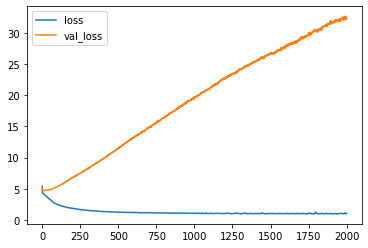

In [42]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


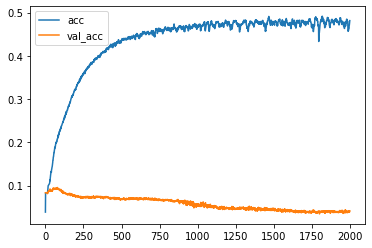

In [43]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Check model output 

In [45]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [58]:
np_input = np.array([[ word2idx['<sos>'] ]])
h = np.zeros((1, LATENT_DIM))
c = np.zeros((1, LATENT_DIM))
    
eos = word2idx['<eos>']
output_sentence = []

for _ in range(max_sequence_length):
    o= model.predict([np_input, h, c])
    print(o.shape)
    probs = o[0,0]
    print(probs.shape)

1/1 [==============================] - 0s 27ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 23ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 22ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 22ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 23ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 23ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 27ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 26ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 27ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 30ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 26ms/step
(1, 1, 3000)
(3000,)
1/1 [==============================] - 0s 22ms/step
(1, 1, 3000)
(3000,)


# Make a sampling model

A sampling model takes as input one word at a time and generates the next word. The first input is the <sos> token, and the first generated word is predicted by the trained model. We need to define a new model with the input of a single model.

In [46]:
def sample_line(model):
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))
    
  eos = word2idx['<eos>']
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = model.predict([np_input, h, c])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break
    
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))
    # make the next input into model
    np_input[0,0] = idx
  return ' '.join(output_sentence)

In [50]:
new_model = tf.keras.models.load_model('poetry_LSTM')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 12, 50)       150000      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                              

In [51]:
# make a sampling model that uses the same layers as defined above, but with trained weights (trained above)
input2 = Input(shape=(1,)) # we'll only input one word at a time

x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)

sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [54]:
# generate a 8 line poem
while True:
  for _ in range(8):
    print(sample_line(sampling_model))

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

1/1 [==============================] - 0s 21ms/step
up one flight from the cellar to the kitchen,
1/1 [==============================] - 0s 24ms/step
('you couldn't call it living, for noon dwelling speaking up home
1/1 [==============================] - 0s 24ms/step
'how shall we?'
1/1 [==============================] - 0s 23ms/step
i guess they'd better drag it through again.
1/1 [==============================] - 0s 23ms/step
'she should, shouldn't she, you're so many times
1/1 [==============================] - 0s 27ms/step
while i invested him with reasons;
1/1 [==============================] - 0s 23ms/step
'don't donkey's ears suggest we shake our own?'
1/1 [==============================] - 0s 22ms/step
'i idled down.'
---generate another? [Y/n]---n
